In [27]:
from CLIP import CLIPCoinEmbedder
import numpy as np
from MLPfusion import FusionLoss, MLPFusion
import importlib
import image_loader

# Reload the module to apply changes
importlib.reload(image_loader)


<module 'image_loader' from 'f:\\BA_Code\\image_loader.py'>

In [19]:
obverse_folder = r"F:\data_ba\kleinsilber_linz\kleinsilber_linz\obverse"
reverse_folder = r"F:\data_ba\kleinsilber_linz\kleinsilber_linz\reverse"
type_folder = r"F:\data_ba\wetransfer_kleinsilber_nach_typen_2024-10-23_1100\Kleinsilber_nach_Typen"

obverse_dataset = image_loader.CoinDataset(
    obverse_folder=obverse_folder,  
    reverse_folder=reverse_folder,
    label="obverse",
    use_grayscale=True,
    type_folder=type_folder
)

reverse_dataset = image_loader.CoinDataset(
    obverse_folder=obverse_folder,  
    reverse_folder=reverse_folder,
    label="reverse",
    use_grayscale=True,
    type_folder=type_folder
)


In [3]:
clip_model_ob = CLIPCoinEmbedder(obverse_dataset, device="cuda")
clip_model_rev = CLIPCoinEmbedder(reverse_dataset, device="cuda")

In [4]:
image_embeddings_ob, text_embeddings_ob, filenames_ob, base_text_ob = clip_model_ob.extract_embeddings()
image_embeddings_rev, text_embeddings_rev, filenames_rev, base_text_rev = clip_model_rev.extract_embeddings()

In [5]:
len(image_embeddings_ob)

741

In [6]:
len(image_embeddings_rev)

740

In [7]:
len(filenames_ob)

741

In [8]:
filenames_ob[15]

'00035a00.jpg'

In [9]:
base_text_ob[15]

'This is the obverse of an ancient Celtic coin depicting Karlstein.'

In [20]:
import torch
import torch.optim as optim

In [14]:
image_embeddings_ob, image_embeddings_rev = np.array(image_embeddings_ob), np.array(image_embeddings_rev)
text_embeddings_ob, text_embeddings_rev = np.array(text_embeddings_ob), np.array(text_embeddings_rev)

In [15]:
image_embeddings_ob.shape

(741, 512)

In [17]:
text_embeddings_ob.shape

(741, 512)

In [12]:
def train_mlp(img_embs, txt_embs):
    # Initialize model, optimizer, and loss function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    fusion_model = MLPFusion().to(device)
    optimizer = optim.Adam(fusion_model.parameters(), lr=0.001)
    loss_fn = FusionLoss()

    # Convert embeddings to PyTorch tensors
    img_embs = torch.tensor(img_embs, dtype=torch.float32).to(device)
    txt_embs = torch.tensor(txt_embs, dtype=torch.float32).to(device)
    labels = torch.ones(img_embs.shape[0], dtype=torch.float32).to(device)  # 1 for positive pairs

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        fused_img = fusion_model(img_embs, txt_embs)
        fused_txt = fusion_model(txt_embs, img_embs)
        
        loss = loss_fn(fused_img, fused_txt, labels)
        
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    print("Training completed!")
    return fused_img

In [18]:
print("----------Training Obverse----------")
fused_embeddings_ob = train_mlp(image_embeddings_ob, text_embeddings_ob)

print("----------Training Reverse----------")
fused_embeddings_rev = train_mlp(image_embeddings_rev, text_embeddings_rev)

----------Training Obverse----------
Epoch 1/10, Loss: 0.4162
Epoch 2/10, Loss: 0.1239
Epoch 3/10, Loss: 0.0504
Epoch 4/10, Loss: 0.0248
Epoch 5/10, Loss: 0.0152
Epoch 6/10, Loss: 0.0105
Epoch 7/10, Loss: 0.0076
Epoch 8/10, Loss: 0.0057
Epoch 9/10, Loss: 0.0044
Epoch 10/10, Loss: 0.0035
Training completed!
----------Training Reverse----------
Epoch 1/10, Loss: 0.3663
Epoch 2/10, Loss: 0.1053
Epoch 3/10, Loss: 0.0380
Epoch 4/10, Loss: 0.0211
Epoch 5/10, Loss: 0.0131
Epoch 6/10, Loss: 0.0084
Epoch 7/10, Loss: 0.0057
Epoch 8/10, Loss: 0.0041
Epoch 9/10, Loss: 0.0032
Epoch 10/10, Loss: 0.0026
Training completed!


In [21]:
fused_embeddings_ob = fused_embeddings_ob.detach().cpu().numpy()
fused_embeddings_rev = fused_embeddings_rev.detach().cpu().numpy()

In [22]:
fused_embeddings_ob.shape

(741, 128)

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
def show_tsne(fused_embeddings, category="Obverse"):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    fused_embeddings_2d = tsne.fit_transform(fused_embeddings)

    plt.scatter(fused_embeddings_2d[:, 0], fused_embeddings_2d[:, 1], alpha=0.6)
    plt.title(f"t-SNE of Fused Image-Text Embeddings ({category})")
    plt.show()

c:\Users\Kenan\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Kenan\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Kenan\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Kenan\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Kenan\AppData\Local\Programs\Python\Python310\lib\subp

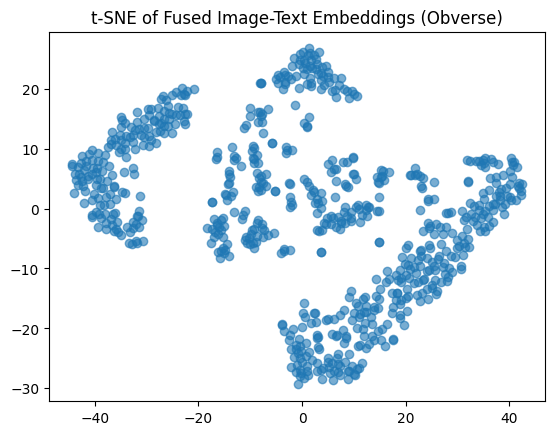

In [27]:
show_tsne(fused_embeddings_ob, category="Obverse")

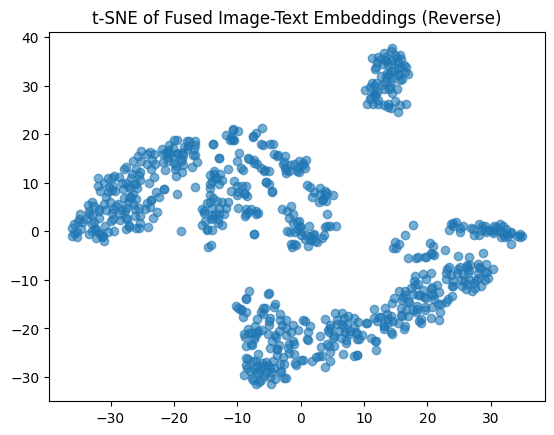

In [28]:
show_tsne(fused_embeddings_rev, category="Reverse")

In [ ]:
def save_embedings(embeddings, filenames, base_text, category):
    extension = "ob" if category.lower() == "obverse" else "rev"
    
    np.save(f"fused_embeddings_{extension}.npy", embeddings)
    with open(f"fused_filenames_{extension}.txt", "w", encoding="utf-8") as f:
        for filename in filenames:
            f.write(filename + "\n")

    with open(f"fused_base_texts_{extension}.txt", "w", encoding="utf-8") as f:
        for text in base_text:
            f.write(text + "\n")
    print(f"Saved embeddings, filenames, and base texts for {category}.")

In [30]:
save_embedings(fused_embeddings_ob, filenames_ob, base_text_ob, "Obverse")
save_embedings(fused_embeddings_rev, filenames_rev, base_text_rev, "Reverse")

Saved embeddings, filenames, and base texts for Obverse.
Saved embeddings, filenames, and base texts for Reverse.


In [22]:
def load_embeddings(category):
    extension = "ob" if category.lower() == "obverse" else "rev"
    embeddings = np.load(f"fused_embeddings_{extension}.npy")

    with open(f"fused_filenames_{extension}.txt", "r", encoding="utf-8") as f:
        filenames = [line.strip() for line in f.readlines()]

    with open(f"fused_base_texts_{extension}.txt", "r", encoding="utf-8") as f:
        base_texts = [line.strip() for line in f.readlines()]

    print(f"Loaded embeddings, filenames, and base texts for {category}.")
    return embeddings, filenames, base_texts

In [23]:
fused_embeddings_ob_test, filenames_ob_test, base_text_ob_test = load_embeddings("Obverse")
fused_embeddings_rev_test, filenames_rev_test, base_text_rev_test = load_embeddings("Reverse")

Loaded embeddings, filenames, and base texts for Obverse.
Loaded embeddings, filenames, and base texts for Reverse.


In [7]:
fused_embeddings_ob_test == fused_embeddings_ob

NameError: name 'fused_embeddings_ob' is not defined

In [38]:
fused_embeddings_rev_test == fused_embeddings_rev

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [24]:
import random

In [26]:
fused_embeddings = torch.tensor(fused_embeddings_rev_test)

In [9]:
random_indices = random.sample(range(len(filenames_rev_test)), 5)

In [9]:
def cosine_similarity(a, b):
    return torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

In [10]:
def find_index(element, li):
    for i in range(len(li)):
        if element == li[i]:
            return i

In [11]:
find_index("A.317_rev_box.jpg", filenames_rev_test)

263

In [48]:
def show_images_for_sim_coins(idx, embedings, filenames, dataset):
    ref_idx = idx # find_index("A.317_rev_box.jpg", filenames_rev_test)
    ref_embedding = embedings[ref_idx]
    ref_filename = filenames[ref_idx]
    similarities = [cosine_similarity(ref_embedding, embedings[i]) for i in range(len(filenames))]
    sorted_indices = np.argsort(similarities)[::-1] 
    most_similar_idx = sorted_indices[1]
    most_dissimilar_idx = sorted_indices[-1]
    similar_filename = filenames[most_similar_idx]
    dissimilar_filename = filenames[most_dissimilar_idx]
    print(f"Reference Image: {ref_filename}")
    print(f"Most Similar Image: {similar_filename} (Similarity: {similarities[most_similar_idx]:.4f})")
    print(f"Most Dissimilar Image: {dissimilar_filename} (Similarity: {similarities[most_dissimilar_idx]:.4f})")
    # Plot the images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.title("Reference Image")
    dataset.show_image(ref_idx)

    plt.subplot(1, 3, 2)
    plt.title("Most Similar Image")
    dataset.show_image(most_similar_idx)

    plt.subplot(1, 3, 3)
    plt.title("Most Dissimilar Image")
    dataset.show_image(most_dissimilar_idx)

    plt.show()


Reference Image: K0937_r.jpg
Most Similar Image: MC0780_r.jpg (Similarity: 0.9998)
Most Dissimilar Image: A.266_rev_box.jpg (Similarity: 0.9973)


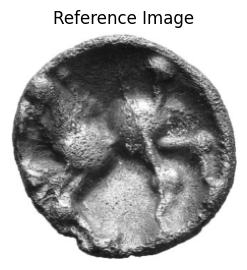

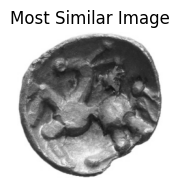

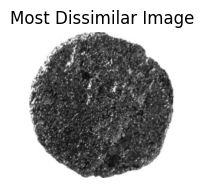

In [52]:
show_images_for_sim_coins(500, torch.tensor(fused_embeddings_rev_test), filenames_rev_test, reverse_dataset)

In [35]:
import os
from PIL import Image

In [62]:
def show_images_for_sim_coins(idx, embeddings, filenames, base_folder, category, num_similar=3, num_dissimilar=3):
    """
    Displays the reference coin image along with the most similar and dissimilar images.

    :param idx: Index of the reference image.
    :param embeddings: Fused embeddings of images.
    :param filenames: List of filenames corresponding to embeddings.
    :param base_folder: Base path where the images are stored.
    :param category: Either "obverse" or "reverse" to determine the folder.
    :param num_similar: Number of most similar images to show.
    :param num_dissimilar: Number of most dissimilar images to show.
    """

    # Determine the full path to images
    folder_path = os.path.join(base_folder, category) 

    # Get the reference image and its embedding
    ref_embedding = embeddings[idx]
    ref_filename = filenames[idx]
    ref_image_path = os.path.join(folder_path, ref_filename)

    # Compute cosine similarity between reference and all embeddings
    similarities = [cosine_similarity(ref_embedding, embeddings[i]) for i in range(len(filenames))]

    # Get sorted indices based on similarity
    sorted_indices = np.argsort(similarities)[::-1]  # Descending order
    most_similar_indices = sorted_indices[1:num_similar+1]  # Skip self
    most_dissimilar_indices = sorted_indices[-num_dissimilar:]  # Least similar

    # Create figure
    fig, axes = plt.subplots(2, num_similar + 1, figsize=(18, 6))

    # Helper function to load and display an image
    def load_and_show(ax, filename, title):
        img_path = os.path.join(folder_path, filename)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(title, fontsize=10)
        else:
            ax.set_title("Image Not Found", fontsize=10)
        ax.axis("off")

    # Show reference image
    load_and_show(axes[0, 0], ref_filename, f"Reference\n{ref_filename}")
    load_and_show(axes[1, 0], ref_filename, f"Reference\n{ref_filename}")


    # Show most similar images
    for i, sim_idx in enumerate(most_similar_indices):
        sim_filename = filenames[sim_idx]
        load_and_show(axes[0, i + 1], sim_filename, f"Similar {i+1}\n{sim_filename}")

    # Show most dissimilar images
    for i, dissim_idx in enumerate(most_dissimilar_indices):
        dissim_filename = filenames[dissim_idx]
        load_and_show(axes[1, i + 1], dissim_filename, f"Dissimilar {i+1}\n{dissim_filename}")

    # Adjust layout
    plt.tight_layout()
    plt.show()


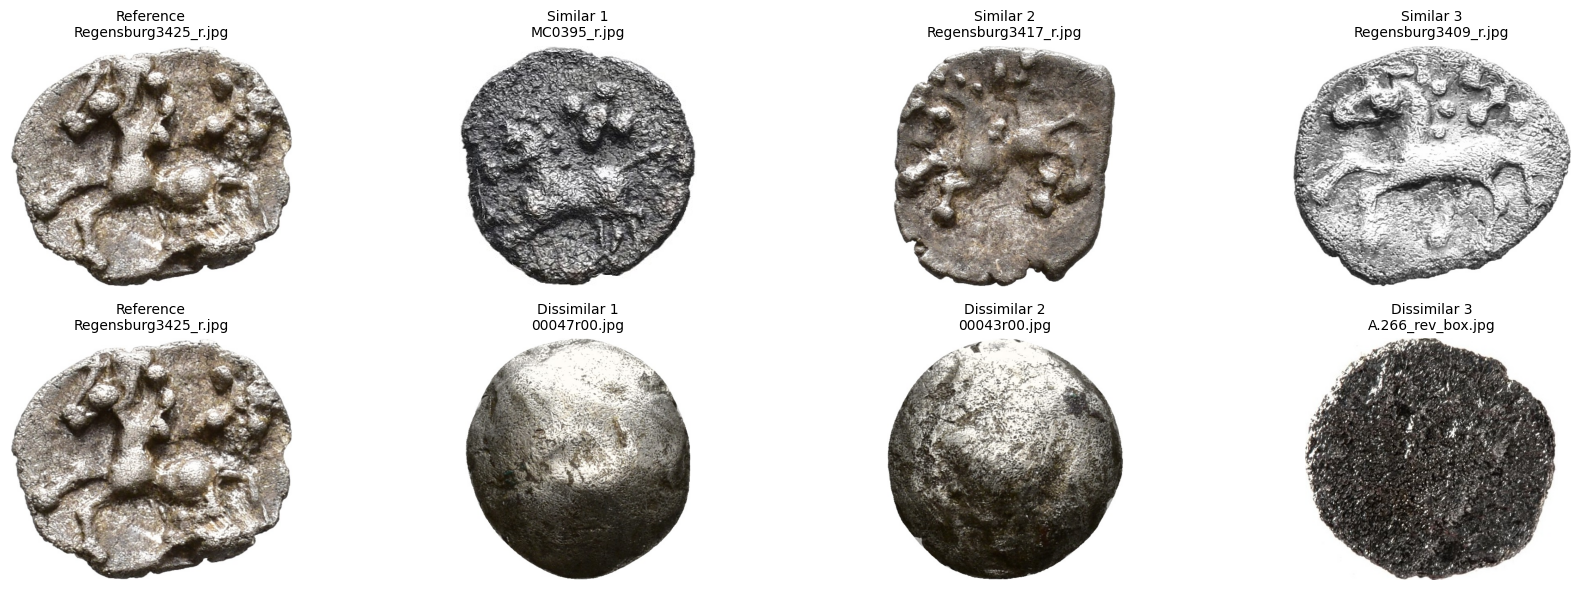

In [ ]:

base_folder = "F:/data_ba/kleinsilber_linz/kleinsilber_linz"
category = "reverse"


show_images_for_sim_coins(700, torch.tensor(fused_embeddings_rev_test), filenames_rev_test, base_folder, category)

# show_images_for_sim_coins(500, torch.tensor(fused_embeddings_rev_test), filenames_rev_test)

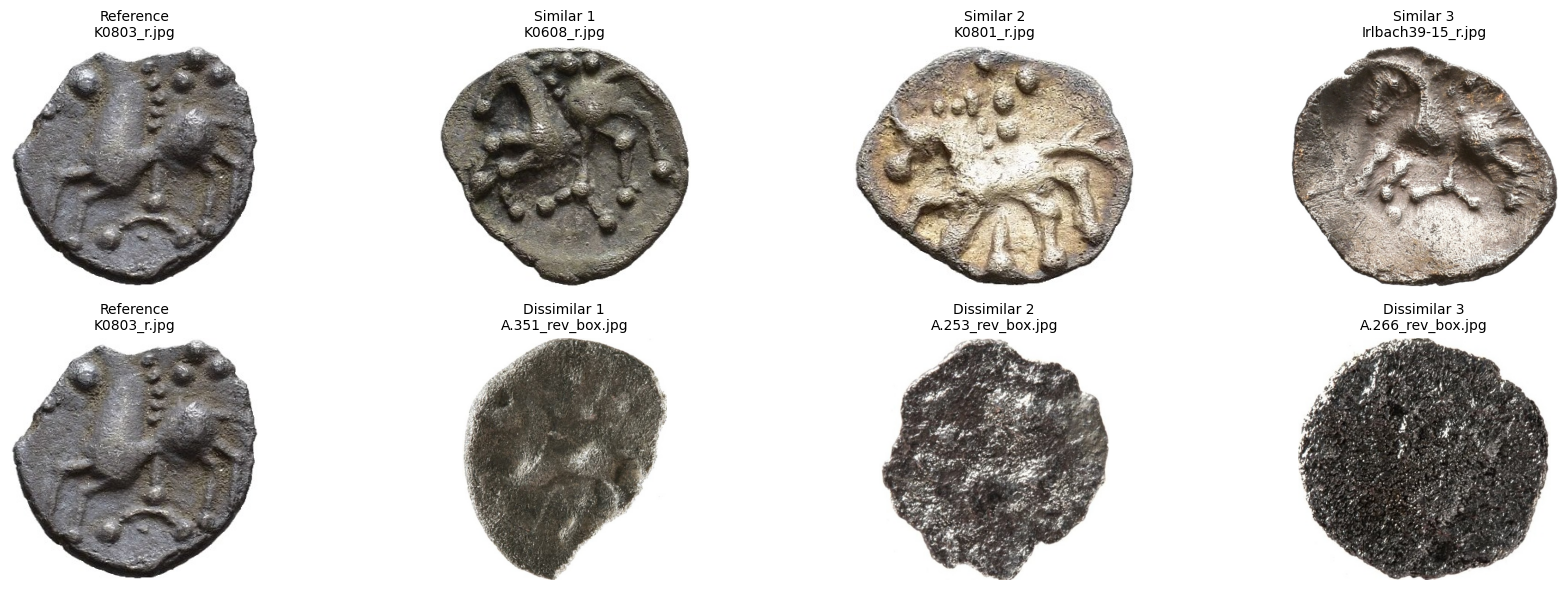

In [64]:
show_images_for_sim_coins(453, torch.tensor(fused_embeddings_rev_test), filenames_rev_test, base_folder, "reverse")

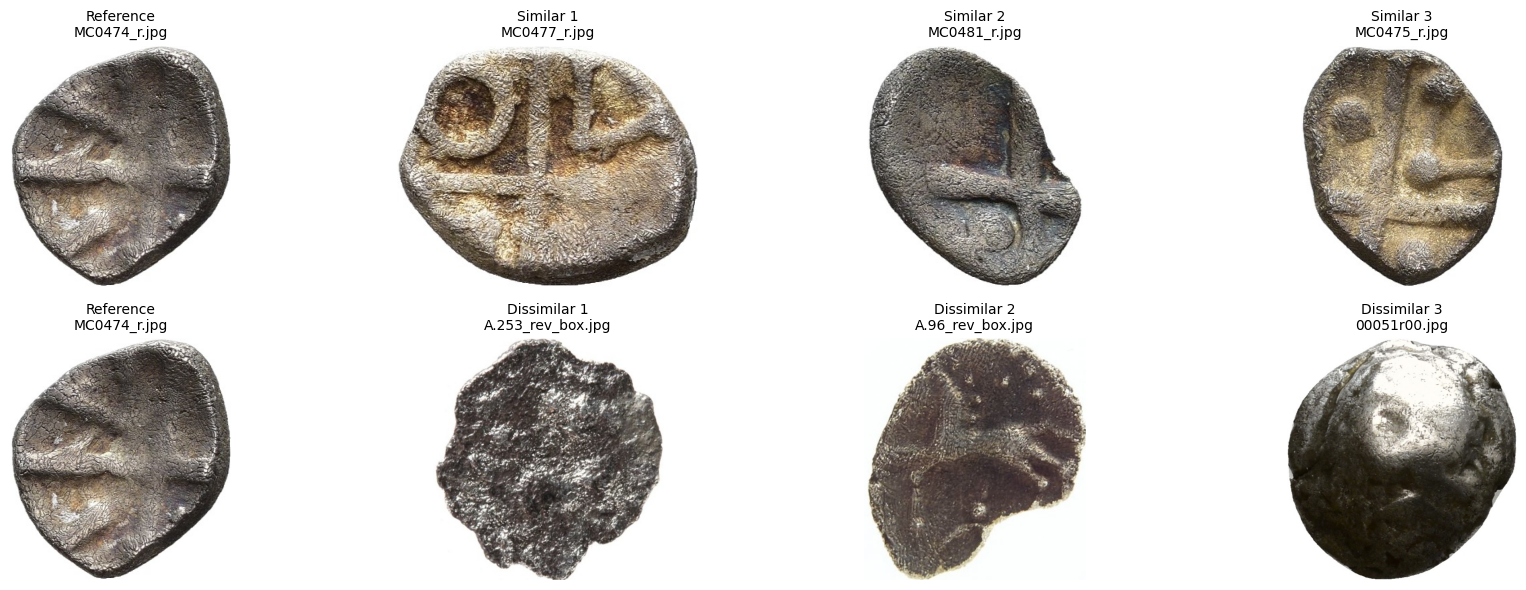

In [65]:
show_images_for_sim_coins(564, torch.tensor(fused_embeddings_rev_test), filenames_rev_test, base_folder, "reverse")

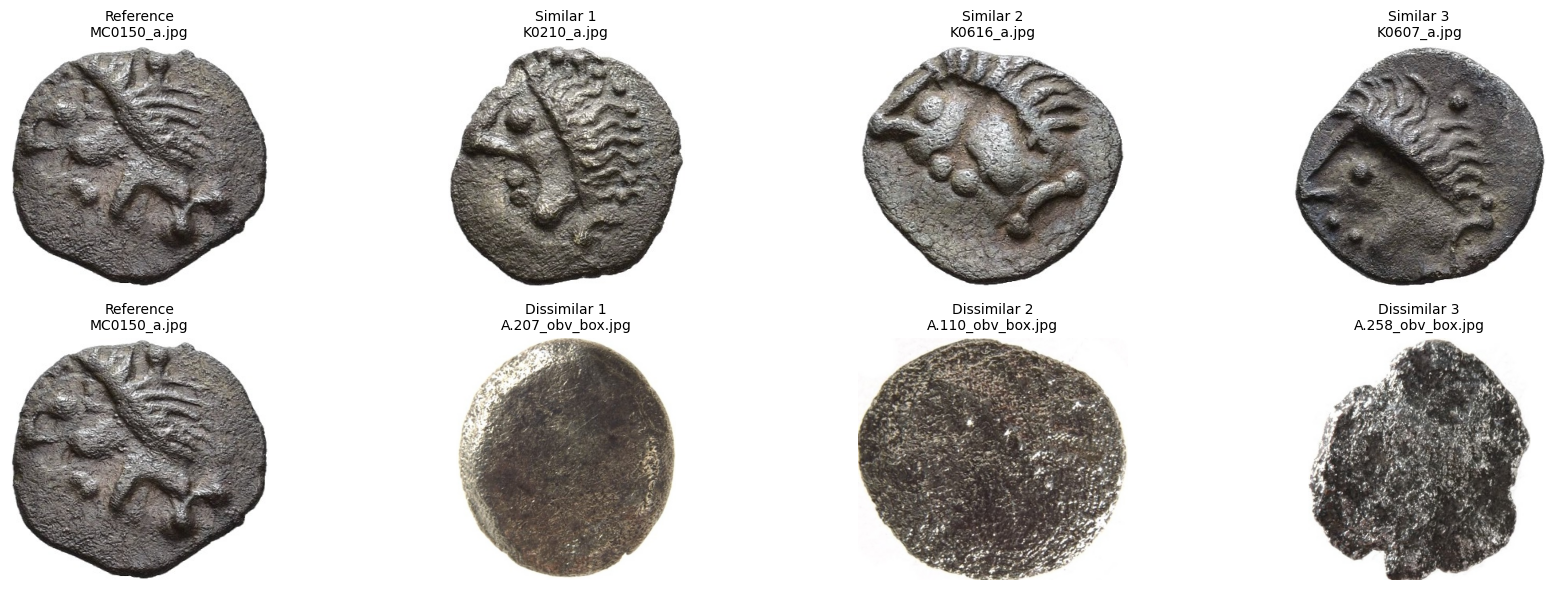

In [67]:
show_images_for_sim_coins(532, torch.tensor(fused_embeddings_ob_test), filenames_ob_test, base_folder, "obverse")

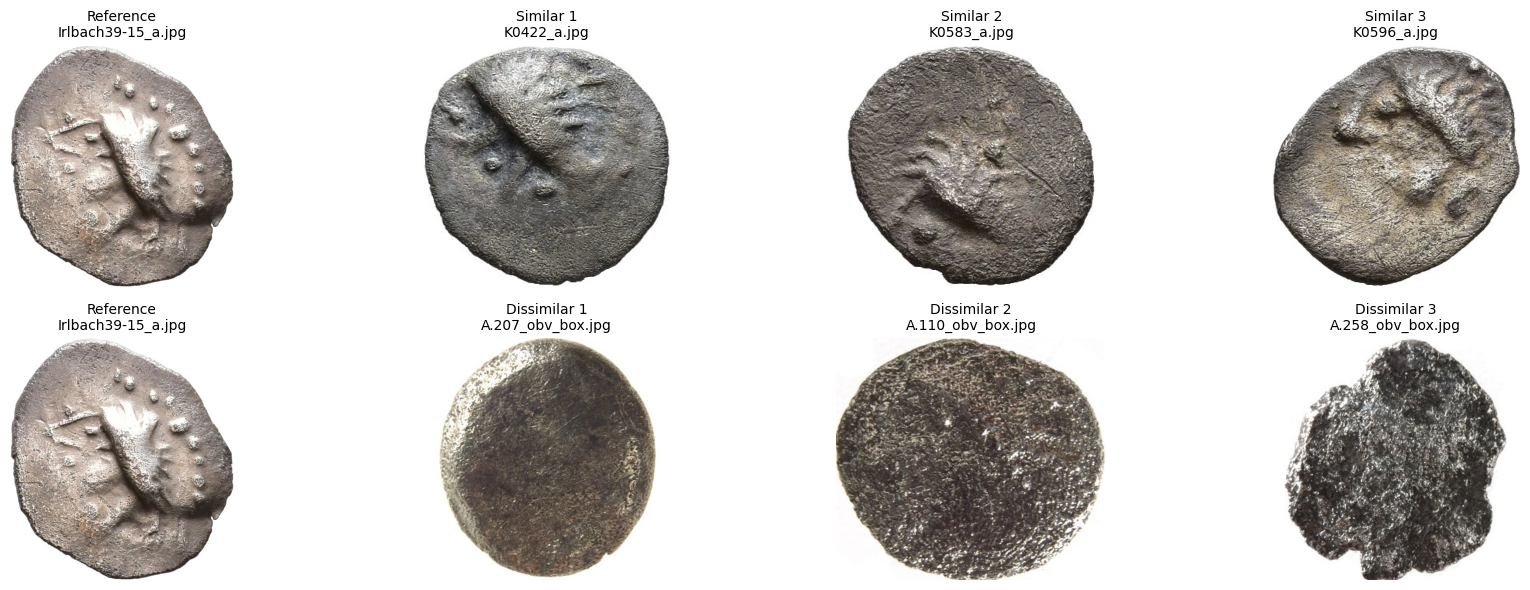

In [68]:
show_images_for_sim_coins(323, torch.tensor(fused_embeddings_ob_test), filenames_ob_test, base_folder, "obverse")

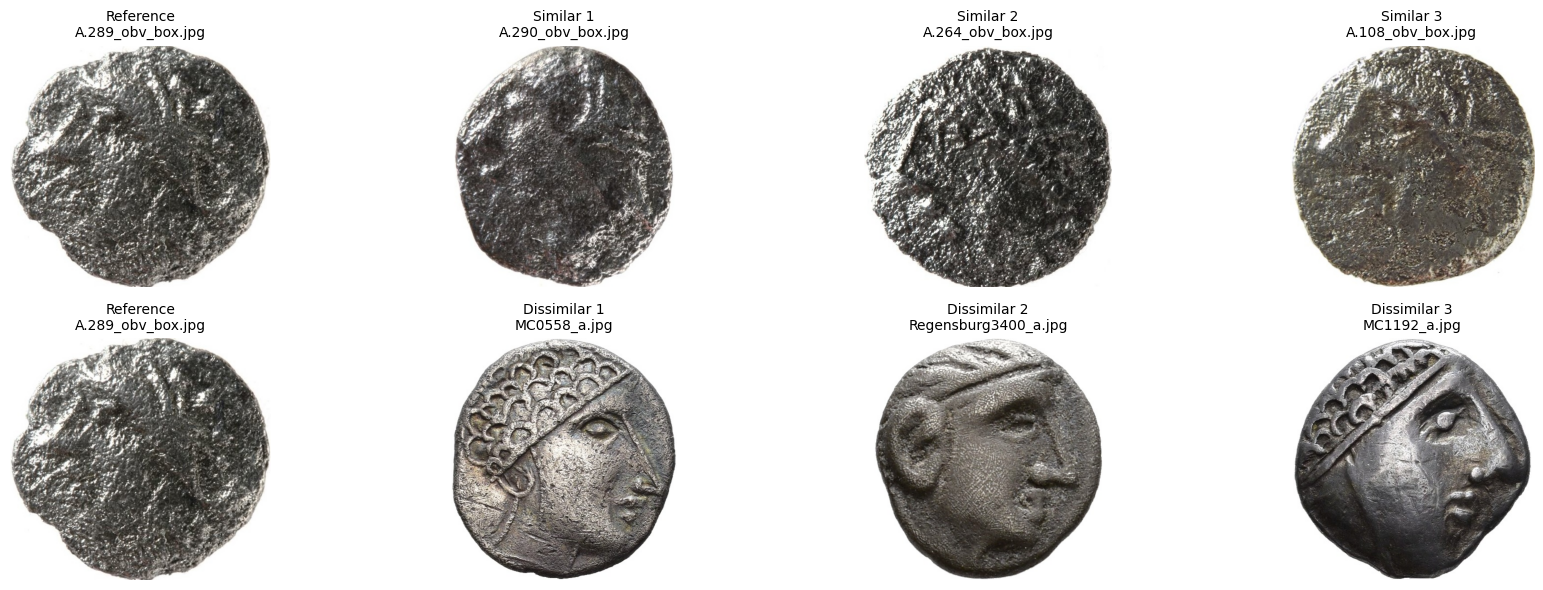

In [69]:
show_images_for_sim_coins(234, torch.tensor(fused_embeddings_ob_test), filenames_ob_test, base_folder, "obverse")